In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import statsmodels.api as sm

import skimage
from skimage import data, img_as_float
import skimage.transform as trans

import rasterio
import fiona

import cartopy

import numpy as np

In [2]:
import sys

import cartopy.crs as ccrs
import cartopy.feature as cfeature

sys.path.append(r"..\..")
import pyphenocam

sys.path.append(r"J:\Projects\NCCSC\phenocam\Tools\DaymetPy\daymetpy")
import daymetpy

In [3]:
base_dname = r"J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge"
site_name = "nationalelkrefuge"

In [4]:
site = pyphenocam.dataaccess.get_site(site_name)
site.x, site.y

(-110.737824, 43.488931)

In [5]:
year = 2016
jday = 153

### Read in landsat data

LC80380302016153LGN00


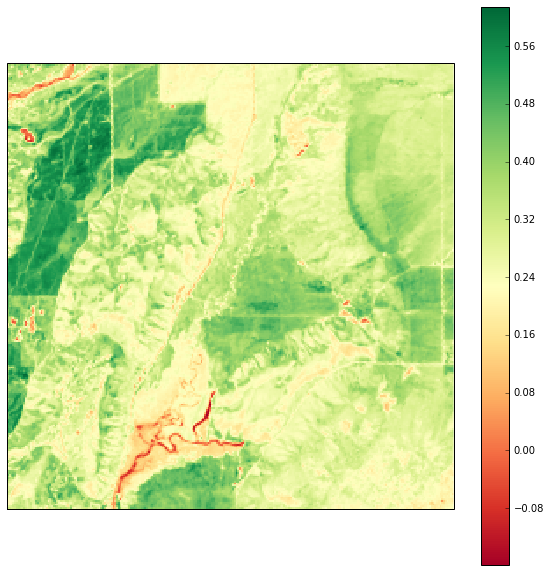

In [6]:
%matplotlib inline
landsat_dname = os.path.join(base_dname, 'Landsat')
scene_name = [f for f in os.listdir(landsat_dname) if f.startswith('LC')][0]                            

landsat_dname = os.path.join(landsat_dname, 'SceneSubset')
landsat_fname = os.path.join(landsat_dname, scene_name[:9]+'{}{}LGN00_ndvi.tif'.format(year, jday))
scene_name = os.path.split(landsat_fname)[1].split('_')[0]

landsat = rasterio.open(landsat_fname)
landsat_data = np.squeeze(landsat.read(masked=True))

utm_zone = landsat.crs.wkt.split('UTM zone ')[1].split('N"')[0]
landsat_proj = ccrs.UTM(zone=utm_zone, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
landsat_extents = [landsat.bounds.left, landsat.bounds.right, 
                   landsat.bounds.bottom, landsat.bounds.top]

print scene_name
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

im = ax.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, 
          cmap=mpl.cm.RdYlGn, interpolation='none')
plt.colorbar(im)

### Read in 30m elevation data

In [8]:
utm_dname = os.path.join(base_dname, "ArcScene", "InputData", "UTM")
elev_subset_fname = os.path.join(utm_dname, "NED_30m.tif")

elev = rasterio.open(elev_subset_fname)
dem_data = np.squeeze(elev.read(masked=True))

elev_extents = [elev.bounds.left, elev.bounds.right, elev.bounds.bottom, elev.bounds.top]

RasterioIOError: 'J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\ArcScene\InputData\UTM\NED_30m.tif' not recognized as a supported file format. 

<IPython.core.display.Javascript object>


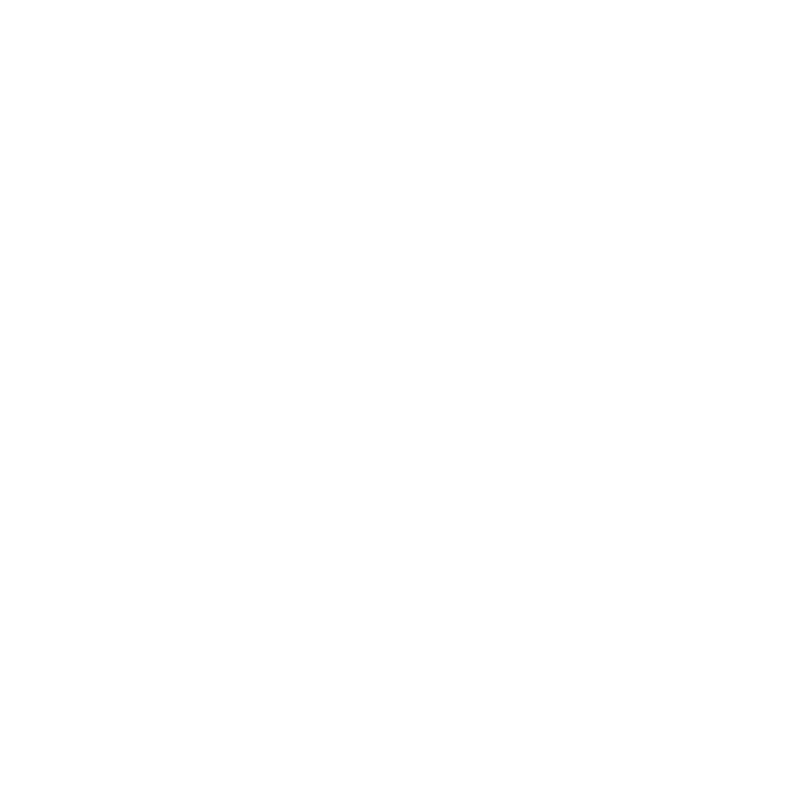

NameError: name 'dem_data' is not defined

<IPython.core.display.Javascript object>


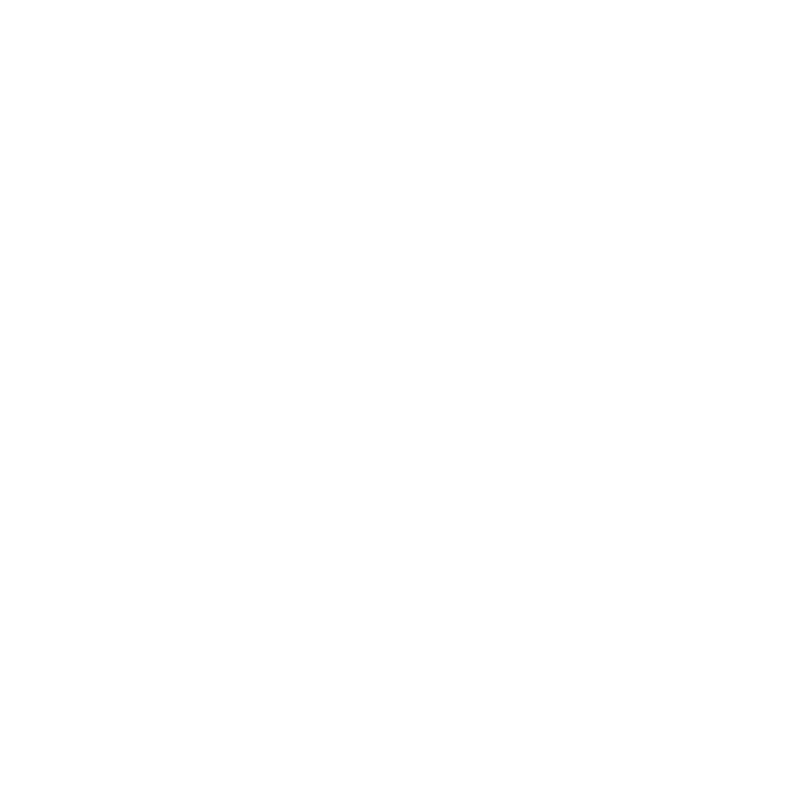

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()#projection=landsat_proj)
im = ax.imshow(dem_data, origin='upper', #extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')
plt.colorbar(im)

# Fit a plane to the pixels around a single pixel

In [9]:
from affine import Affine
T1 = landsat.affine * Affine.translation(0.5, 0.5)

rc2xy = lambda rc: (rc[1], rc[0]) * T1

In [10]:
dem_indices = np.indices(dem_data.shape)
dem_xy = np.apply_along_axis(func1d=rc2xy ,arr=dem_indices, axis=0)

In [11]:
row = 242
col = 127

def get_pix_data(row, col):
    data = dem_data[row-1:row+2, col-1:col+2]
    xy = dem_xy[:, row-1:row+2, col-1:col+2]
    return data, xy

data, xy = get_pix_data(row, col)

In [12]:
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

In [13]:
def calc_aspect(est):
    params2 = est.params

    intercept, xslope, yslope = params2
    yslope *= -1 #accound for descending utm coordingates

    aspect = 57.29578 * np.arctan2(yslope, -1*xslope)

    if aspect < 0:
        cell = 90.0 - aspect
    elif aspect > 90.0:
        cell = 360.0 - aspect + 90.0
    else:
        cell = 90.0 - aspect

    return cell

def calc_slope(est):
    params2 = est.params
    intercept, xslope, yslope = params2
    yslope *= -1 #account for descending utm coordingates

    max_slope = (yslope**2 + xslope**2)**.5
    
    return np.degrees(max_slope)

# aspect = calc_aspect(est)
# slope = calc_slope(est)

# print calc_aspect(est)
# print calc_slope(est)

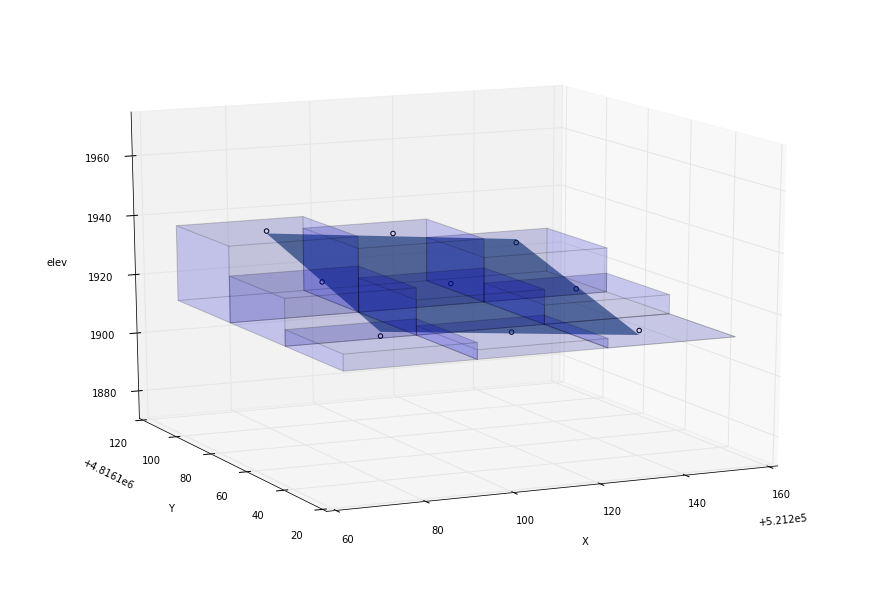

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
# TODO add image and put this code into an appendix at the bottom
from mpl_toolkits.mplot3d import Axes3D

row, col = 210, 131

def plot_3d_slope(row, col, ax, fall_line=False):
    
    data, xy = get_pix_data(row, col)

    X = xy.reshape(2, 9).T
    y = data.flatten()

    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    xx1, xx2 = xy[0,:,:], xy[1,:,:]
    # plot the hyperplane by evaluating the parameters on the grid
    Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

    # plot hyperplane
    surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)
    
    # plot data points - points over the HP are white, points below are black
    resid = y - est.predict(X)
    ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


    xpos2 = xx1.flatten()-15
    ypos2 = xx2.flatten()-15
    zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
    dx2 = 30 * np.ones_like(xx1.flatten())
    dy2 = 30 * np.ones_like(xx2.flatten())
    dz2 = y.flatten() - y.min()

    ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.10)
    
    if fall_line:
        center_x = xpos2[4]+15
        center_y = ypos2[4]+15
        center_z = y.flatten()[4]

        aspect = calc_aspect(est)
        slope = calc_slope(est)
        dx = 30 * np.sin(np.deg2rad(aspect))
        dy = 30 * np.cos(np.deg2rad(aspect))
        fall_x = center_x+dx
        fall_y = center_y+dy

        fall_dist = distance.euclidean((center_x, center_y), 
                                       (fall_x, fall_y))
        fall_z = center_z -(fall_dist*slope)
        ax.plot((center_x, fall_x), 
                (center_y, fall_y), 
                (center_z, fall_z), color='r', lw=6, alpha=0.5)
    
# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)





# ax.plot((xpos2[4]+15, xpos2[5]+15), 
#         (ypos2[4]+15, ypos2[5]), 
#         (y.flatten()[4], y.flatten()[5]), color='r', solid_capstyle="projecting")


# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

plot_3d_slope(row, col, ax)

set_aspect_equal_3d(ax)



In [7]:
%matplotlib inline
from scipy.spatial import distance

row, col = 207, 132
data, xy = get_pix_data(row, col)

X = xy.reshape(2, 9).T
y = data.flatten()

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

xx1, xx2 = xy[0,:,:], xy[1,:,:]
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)




# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


xpos2 = xx1.flatten()-15
ypos2 = xx2.flatten()-15
zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
dx2 = 30 * np.ones_like(xx1.flatten())
dy2 = 30 * np.ones_like(xx2.flatten())
dz2 = y.flatten() - y.min()

ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.10)



center_x = xpos2[4]+15
center_y = ypos2[4]+15
center_z = y.flatten()[4]

aspect = calc_aspect(est)
slope = calc_slope(est)
dx = 30 * np.sin(np.deg2rad(aspect))
dy = 30 * np.cos(np.deg2rad(aspect))
fall_x = center_x+dx
fall_y = center_y+dy

fall_dist = distance.euclidean((center_x, center_y), 
                               (fall_x, fall_y))
fall_z = center_z -(fall_dist*np.deg2rad(slope))
ax.plot((center_x, fall_x), 
        (center_y, fall_y), 
        (center_z, fall_z), color='r', lw=6, alpha=0.5)

# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

    
set_aspect_equal_3d(ax)

NameError: name 'get_pix_data' is not defined

## Now that we've got all that worked out run it through all the landsat pixels in our image

In [9]:
landsat_fishnet_fname = os.path.join(base_dname, "ArcScene", "landsat_fishnet.bmp")
landsat_index_fname = os.path.join(base_dname, "ArcScene", "landsat_subset_index.bmp")

phenosite = pyphenocam.dataaccess.get_site(site_name)

closest_date = datetime.datetime(year, 1, 1, 12) + datetime.timedelta(jday)
print closest_date
closest_photo_fname = phenosite.get_closest_fname(closest_date)
closest_photo_fname = phenosite.get_local_image_fname(closest_photo_fname, IR=False)
closest_photo_fname_ir = phenosite.get_local_image_fname(closest_photo_fname, IR=True)

2016-06-02 12:00:00


In [10]:
%matplotlib inline


exposure = pyphenocam.headerextraction.get_exposure(closest_photo_fname)
exposure_ir = pyphenocam.headerextraction.get_exposure(closest_photo_fname_ir)
print "Extracted exposure: ", exposure
sample_photo_fname = phenosite.get_closest_fname(closest_date)
local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)
corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                local_fname_ir, 
                                                                float(exposure), 
                                                                float(exposure_ir))
    
def plot_compare():
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(121)


    ax.imshow(sample_image)
    pyphenocam.plotting.format_photo_axes(ax)

    ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)
    pyphenocam.plotting.format_photo_axes(ax2)

    im = ax2.imshow(corrected_ndvi, vmin=0, cmap=mpl.cm.RdYlGn)
    fig.colorbar(im)

Extracted exposure:  21


Extracted exposure:  21


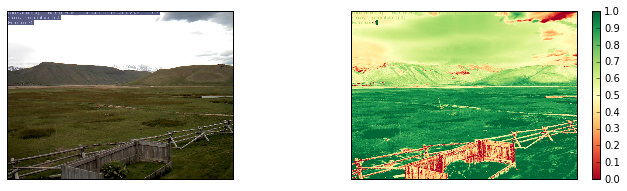

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)



ax.imshow(sample_image)
pyphenocam.plotting.format_photo_axes(ax)


ax2 = fig.add_subplot(122)

pyphenocam.plotting.format_photo_axes(ax2)
exposure = pyphenocam.headerextraction.get_exposure(local_fname)
exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)


print "Extracted exposure: ", exposure

corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                local_fname_ir, 
                                                                float(exposure), 
                                                                float(exposure_ir))
im = ax2.imshow(corrected_ndvi, vmin=0, cmap=mpl.cm.RdYlGn)
fig.colorbar(im)

In [12]:
index_grid = skimage.io.imread(landsat_index_fname)
index_grid = trans.resize(index_grid, (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=True, order=0)

index_grid = np.ma.masked_where(index_grid > 254, index_grid)

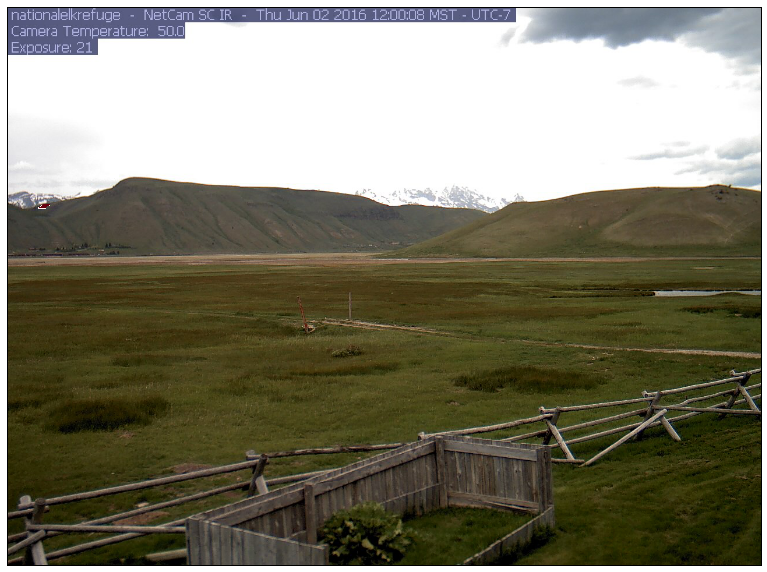

In [13]:
single_pixel = np.logical_and(index_grid[:,:,0]==54, index_grid[:,:,1]==148)

single_pixel = np.ma.asarray(trans.resize(single_pixel, 
            (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

single_pixel.mask = single_pixel==False

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(sample_image)
ax.imshow(single_pixel, alpha = 1.0, cmap=mpl.cm.Reds, interpolation='none')
pyphenocam.plotting.format_photo_axes(ax)

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax_proj = ccrs.LambertConformal()
landsat_proj = ccrs.UTM(zone=12, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
geodetic = ccrs.Geodetic()

fig = plt.figure(figsize=(15, 15))
ax_extent = [phenosite.x - 0.02, phenosite.x + 0.02, phenosite.y - 0.002, phenosite.y + 0.040]

landsat_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

ax = plt.axes(projection=ax_proj)
ax.set_extent(ax_extent, ccrs.Geodetic())
im = ax.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.RdYlGn)

# # ax.set_xmargin(0.05)
# # ax.set_ymargin(0.10)

# mark a known place to help us geo-locate ourselves
locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
ax.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
ax.text(locx+75, locy-15, 'Elk Refuge camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
ax.gridlines()

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
plt.colorbar(im)

# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

In [ ]:
def get_slope_aspect(col, row):
    data, xy = get_pix_data(row, col)

    X = xy.reshape(2, 9).T
    y = data.flatten()

    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    aspect = calc_aspect(est)
    slope = calc_slope(est)
    return slope, aspect

In [ ]:
camx, camy = list(landsat_proj.transform_point(phenosite.x, phenosite.y, geodetic))
camcol, camrow = ~elev.affine * (camx, camy)
cam_elev = dem_data[camrow, camcol]

TOWER_HEIGHT = 3 #meters
cam_elev += TOWER_HEIGHT
print cam_elev

In [ ]:
import math
def dist3d(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2+(z2 -z1)**2)

def azimuth3d(x1, y1, z1, x2, y2, z2):
    return math.degrees(math.atan2((x2-x1),(y2-y1)))

def zenith3d(x1, y1, z1, x2, y2, z2, dist):
    return math.degrees(math.asin((z2-z1)/dist))

In [25]:
def plot_3d_slope(row, col, ax, fall_line=False):
    
    data, xy = get_pix_data(row, col)

    X = xy.reshape(2, 9).T
    y = data.flatten()

    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    xx1, xx2 = xy[0,:,:], xy[1,:,:]
    # plot the hyperplane by evaluating the parameters on the grid
    Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

    # plot hyperplane
    surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)
    
    # plot data points - points over the HP are white, points below are black
    resid = y - est.predict(X)
    ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


    xpos2 = xx1.flatten()-15
    ypos2 = xx2.flatten()-15
    zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
    dx2 = 30 * np.ones_like(xx1.flatten())
    dy2 = 30 * np.ones_like(xx2.flatten())
    dz2 = y.flatten() - y.min()

    ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.10)
    
    if fall_line:
        center_x = xpos2[4]+15
        center_y = ypos2[4]+15
        center_z = y.flatten()[4]

        aspect = calc_aspect(est)
        slope = np.deg2rad(calc_slope(est))
        dx = 30 * np.sin(np.deg2rad(aspect))
        dy = 30 * np.cos(np.deg2rad(aspect))
        fall_x = center_x+dx
        fall_y = center_y+dy

        fall_dist = distance.euclidean((center_x, center_y), 
                                       (fall_x, fall_y))
        fall_z = center_z -(fall_dist*slope)
        ax.plot((center_x, fall_x), 
                (center_y, fall_y), 
                (center_z, fall_z), color='r', lw=6, alpha=0.5)

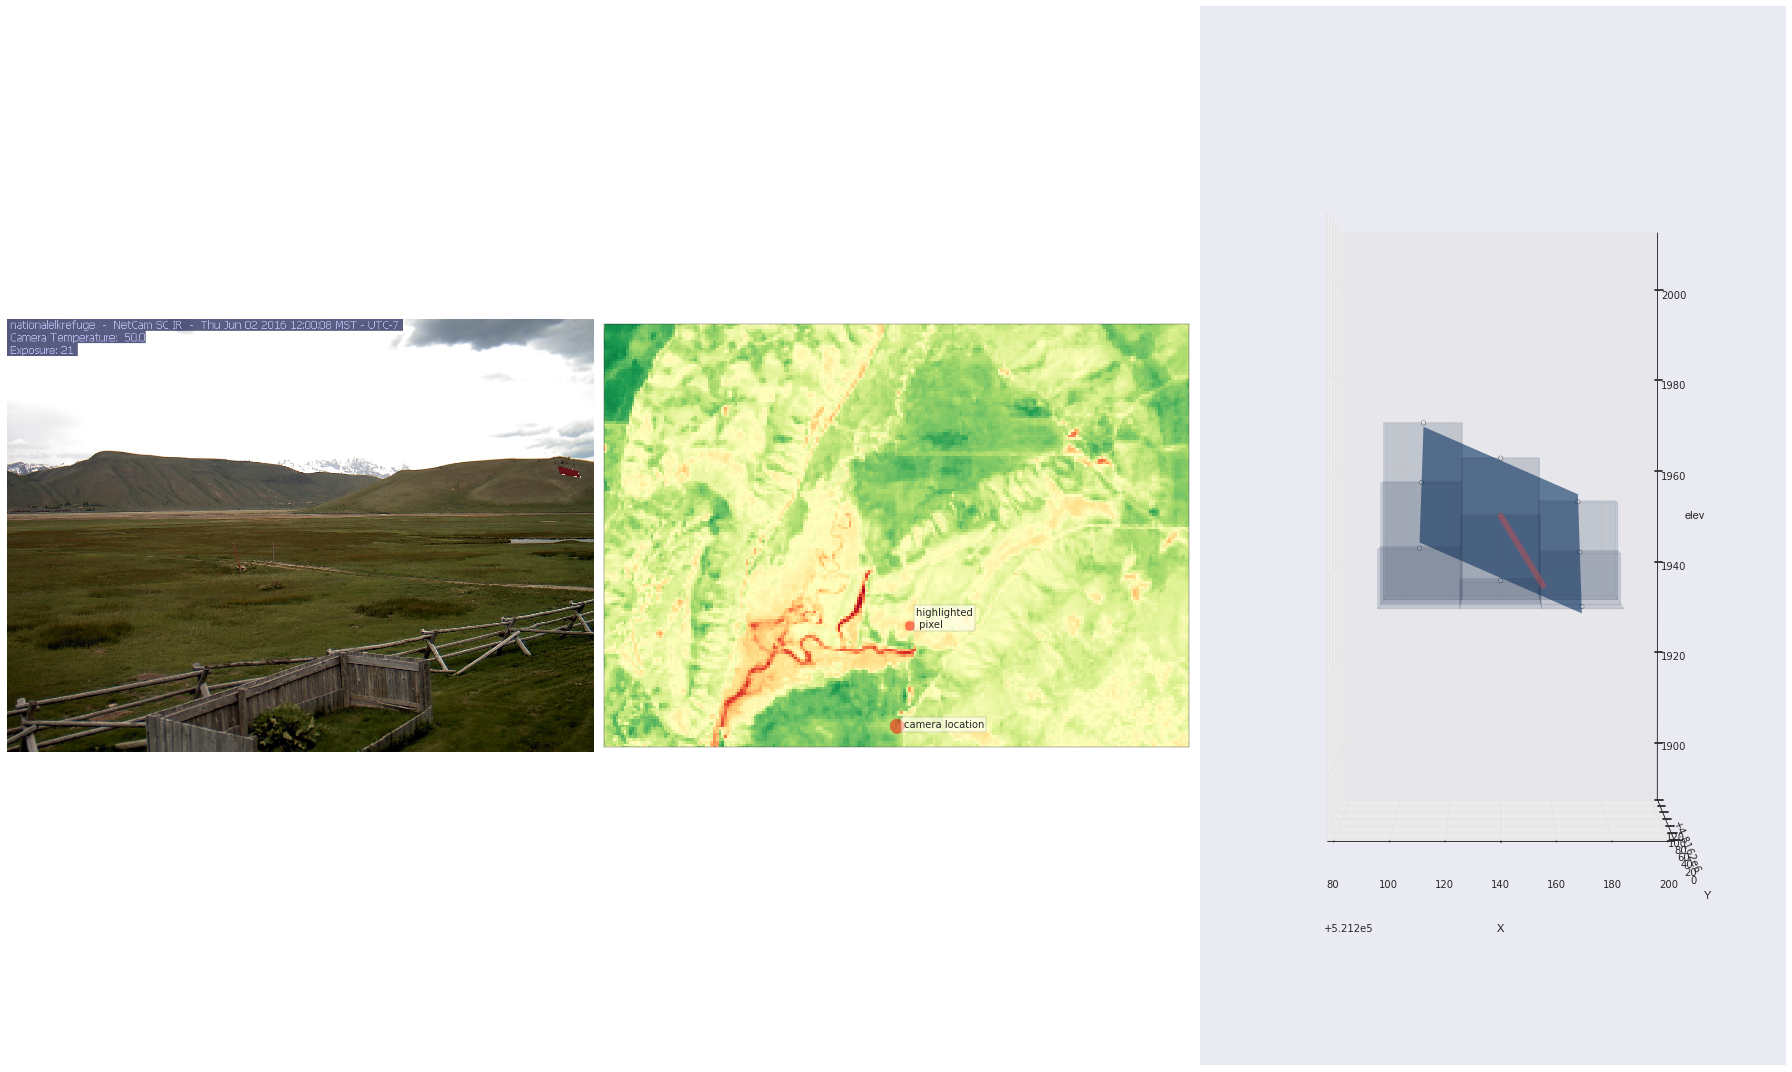

In [211]:
%matplotlib inline
from ipywidgets import interactive

col_index, row_index = 0,0
#col_index=127, row_index=250
def plot_one(col_index=132, row_index=207):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)

    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot(131)
    ax.imshow(sample_image)
    ax.imshow(single_pixel, alpha = 0.75, cmap=mpl.cm.Reds, interpolation='none')
    pyphenocam.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(132, projection=ax_proj)
    ax_extent = [phenosite.x - 0.04, phenosite.x + 0.04, phenosite.y - 0.002, phenosite.y + 0.040]
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.RdYlGn)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted \n pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    ax3 = fig.add_subplot(1, 3, 3, projection='3d', azim=-90, elev=1)
    
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('elev')

    plot_3d_slope(row_index, col_index, ax3, fall_line=True)

    set_aspect_equal_3d(ax3)

    
    plt.tight_layout()
    fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "calculatingSlopeAspect.jpg"), dpi=270)
    
interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

In [14]:
#this isn't terribly efficient but a good demonstration/validation of the technique \n",
data = np.array(index_grid[:, :, :2]).astype(np.uint8)
dtype = data.dtype.descr * 2
struct = data.view(dtype)
uniq = np.unique(struct)

results = {}
mapped_output = np.zeros(np.squeeze(index_grid[:,:,1]).shape)

In [15]:
import seaborn as sns

In [144]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader



def get_locator(loc=[.9, 0.5, 0.3, 0.3]):
    locator_ax = plt.axes(loc,
                  projection=ccrs.LambertConformal())

    locator_ax.set_extent([-124, -71, 20, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = [0.9375, 0.9375, 0.859375]
        edgecolor = 'black'


        locator_ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)

    plt.plot(landsat_extents[0], landsat_extents[2], '*', 
             markersize=15, color='r', transform=landsat_proj)
#     extent = landsat_proj
#     bigger = 0
#     extent_box = sgeom.box(extent[0]-bigger, extent[2]+bigger, extent[1]-bigger, extent[3]+bigger)
#     locator_ax.add_geometries([extent_box], landsat_proj, color='none',
#                               edgecolor='blue', linewidth=2)
    return locator_ax



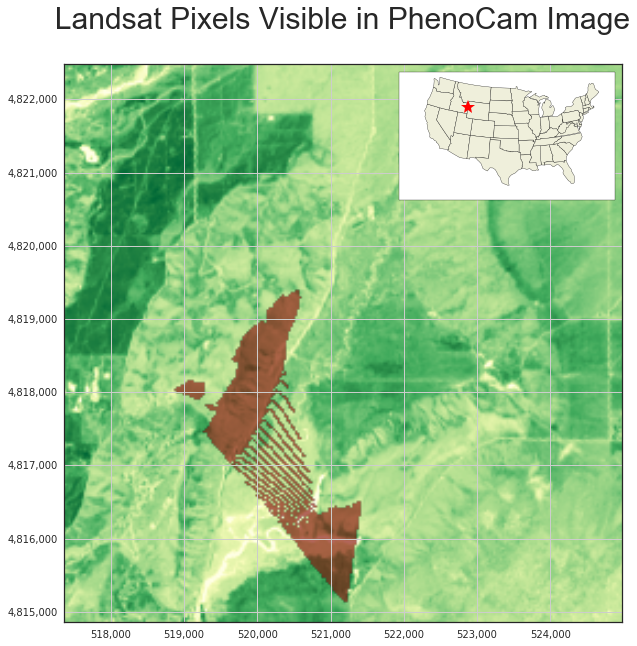

In [147]:
%matplotlib inline
sns.set_style("white")

scene_dname = os.path.join(base_dname, "Landsat", "SceneSubset")
visible_pixels = np.zeros(landsat_data.shape)
for u in uniq:
    try:
        visible_pixels[u[1], u[0]] = 1
    except:
        pass

out_fname = os.path.join(scene_dname, 'mapped', "visible_mask.npy")
np.save(out_fname, visible_pixels)

plt.figure(figsize=(10,10))
landsat_data.mask += landsat_data==44
plt.imshow(landsat_data, vmin=0, vmax=0.7, cmap=mpl.cm.YlGn, interpolation=None, extent=landsat_extents)

# plt.colorbar()
visible_pixels = np.ma.MaskedArray(visible_pixels, mask=visible_pixels==0)
plt.imshow(visible_pixels, cmap='jet_r', alpha=0.6, interpolation=None, extent=landsat_extents)


ax = plt.gca()
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as tkr

def func(x, pos):  # formatter function takes tick label and tick position
    s = '%d' % x
    groups = []
    while s and s[-1].isdigit():
        groups.append(s[-3:])
        s = s[:-3]
    return s + ','.join(reversed(groups))

y_format = tkr.FuncFormatter(func)  # make formatter
majorFormatter = FormatStrFormatter('%d')
ax.yaxis.set_major_formatter(y_format)
ax.xaxis.set_major_formatter(y_format)

locator_ax = get_locator(loc=[.59, 0.65, 0.3, 0.3])
pyphenocam.plotting.format_photo_axes(locator_ax)

ax.xaxis.grid(True)
ax.yaxis.grid(True)

fig = plt.gcf()
fig.suptitle("  Landsat Pixels Visible in PhenoCam Image", fontsize=30)
fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "VisibleLandsatPixels.jpg"), dpi=270)

In [48]:
extent

(155, 163, -11.5, -6)

In [49]:
landsat_extents

[517365.0, 524985.0, 4814865.0, 4822485.0]

In [ ]:
%matplotlib inline
sns.set_style("white")

scene_dname = os.path.join(base_dname, "Landsat", "SceneSubset")
visible_pixels = np.zeros(landsat_data.shape)
for u in uniq:
    try:
        visible_pixels[u[1], u[0]] = 1
    except:
        pass

out_fname = os.path.join(scene_dname, 'mapped', "visible_mask.npy")
np.save(out_fname, visible_pixels)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())

landsat_data.mask += landsat_data==44
ax.imshow(landsat_data, vmin=0, vmax=0.7, cmap=mpl.cm.YlGn, interpolation=None, extent=landsat_extents, transform=landsat_proj)

# # plt.colorbar()
# visible_pixels = np.ma.MaskedArray(visible_pixels, mask=visible_pixels==0)
# ax.imshow(visible_pixels, cmap='jet_r', alpha=0.6, interpolation=None, extent=landsat_extents, transform=landsat_proj)
# ax.gridlines(draw_labels=True)

ax.set_extent(ax_extent)

# fig = plt.gcf()
# # fig.suptitle("Visible Landsat pixels", fontsize=45)
# fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "VisibleLandsatPixels.jpg"), dpi=270)

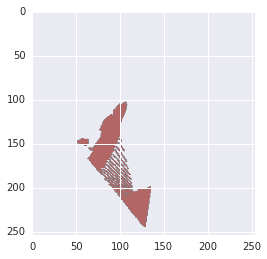

In [32]:
out_fname = os.path.join(scene_dname, 'mapped', "visible_mask.npy")
visible_pixels = np.load(out_fname)
visible_pixels = np.ma.MaskedArray(visible_pixels, mask=visible_pixels==0)
plt.imshow(visible_pixels)
plt.imshow(visible_pixels, cmap='jet_r', alpha=0.6)

In [99]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=len(uniq[::skip])-1)
display(f)

results = {}
i = 0
skip = 1
for col, row in uniq[::skip]:
#     print col, row,
#     print ".",
    f.value = i
    
    single_pixel = np.logical_and(index_grid[:,:,0]==col, index_grid[:,:,1]==row)
    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                    (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]
    phenopixcount = np.count_nonzero(single_pixel)
    try:
        landsatx, landsaty = dem_xy[:, row, col]
        pix_elev = dem_data[row, col]
        slope, aspect = get_slope_aspect(col=col, row=row)
        landsat_ndvi = landsat_data[row, col]
        phenocam_ndvi = np.nanmean(corrected_ndvi[single_pixel>0.95])
        phenocam_ndvi_median = np.nanmedian(corrected_ndvi[single_pixel>0.95])
        
        dist = dist3d(camx, camy, cam_elev, landsatx, landsaty, pix_elev)
        az = azimuth3d(camx, camy, cam_elev, landsatx, landsaty, pix_elev)
        zen = zenith3d(camx, camy, cam_elev, landsatx, landsaty, pix_elev, dist)
        
        results[i] = [col, row, phenopixcount, landsatx, landsaty, pix_elev, 
                      dist, az, zen,
                       slope, aspect, landsat_ndvi, phenocam_ndvi, phenocam_ndvi_median]
        mapped_output[single_pixel>0.95] = landsat_ndvi
    except IndexError:
        print "skipping", col, row
    i+=1
#     if i > 30:
#         break

skipping 255 255


In [180]:
import pandas as pd
data = pd.DataFrame.from_dict(results, orient='index')
data.columns = ["col", "row", "photopixelcount", "landsatx", "landsaty", "landsatelevation",
                "distance", "azimuth", "zenith",
                "pixelslope", "pixelaspect", "landsat_ndvi", "phenocam_ndvi", "phenocam_ndvi_median"]
data.to_csv(os.path.join(base_dname, scene_name + "_results.csv"))
data.row()

,col,row,photopixelcount,landsatx,landsaty,landsatelevation,distance,azimuth,zenith,pixelslope,pixelaspect,landsat_ndvi,phenocam_ndvi,phenocam_ndvi_median
0,50,148,4,518880,4818030,2076.087891,3705.344941,-38.801076,2.669342,20.131163,229.950970,0.200163,0.596040,0.596040
1,51,147,14,518910,4818060,2087.943604,3710.731291,-38.148999,2.848736,16.005384,241.181395,0.205635,0.199718,0.173859
2,51,148,37,518910,4818030,2083.424072,3686.991701,-38.437319,2.796774,18.635442,214.919030,0.241800,0.237375,0.210385
3,51,149,13,518910,4818000,2072.532227,3663.049983,-38.729342,2.644510,26.997351,195.896282,0.254017,0.260432,0.344647
4,52,147,26,518940,4818060,2093.737549,3692.592348,-37.782443,2.952759,15.284708,210.488439,0.205604,0.310454,0.358301
5,52,148,69,518940,4818030,2087.428711,3668.638117,-38.069859,2.873398,19.115376,189.360040,0.243628,0.287310,0.273391
6,52,149,50,518940,4818000,2074.272705,3644.457083,-38.361003,2.685403,27.806591,179.361721,0.240801,0.470042,0.476619
7,53,146,6,518970,4818090,2105.757812,3698.792891,-37.129458,3.134266,14.699193,224.051942,0.208236,0.172448,0.172448
8,53,147,53,518970,4818060,2097.108398,3674.489473,-37.412215,3.019952,19.991484,190.469416,0.224114,0.377253,0.378298
9,53,148,93,518970,4818030,2083.826904,3650.059551,-37.698669,2.831427,23.095523,177.139348,0.249793,0.086171,0.146498


In [ ]:
import pandas as pd
data = pd.read_csv(os.path.join(base_dname, scene_name + "_results.csv"))

In [ ]:
data.shape

In [ ]:
import seaborn
data.pixelslope.plot(kind='hist')

In [ ]:
ave_diff = data.phenocam_ndvi.mean() - data.landsat_ndvi.mean()

In [ ]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

ans = data.landsat_ndvi-data.phenocam_ndvi+ ave_diff
vmax = ans.max()
vmin = ans.min()

center = 1 - vmax/(vmax + abs(vmin))

new_cm = shiftedColorMap(mpl.cm.RdBu, midpoint=center, name='shifted')

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 12))



c = ax.scatter(data.azimuth, data.zenith, c=data.landsat_ndvi-data.phenocam_ndvi+ ave_diff,
               cmap=new_cm, alpha=0.5, lw=0.5, s=((1-(data.distance-data.distance.min())/data.distance.max())*20)**2)

cbar = fig.colorbar(c)
cbar.set_label("diff")
cbar.solids.set_rasterized(True) 
cbar.set_alpha(1)
cbar.draw_all()
ax.set_ylabel('zenith')
ax.set_xlabel('azimuth')

ax.set_xlim(-40, 12)


def resize_all(ax, fontsize=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    
resize_all(ax, 20)

fig = plt.gcf()
fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "CorrelationAllPoints_residuals.jpg"), dpi=270)

In [56]:
from statsmodels.nonparametric.smoothers_lowess import lowess

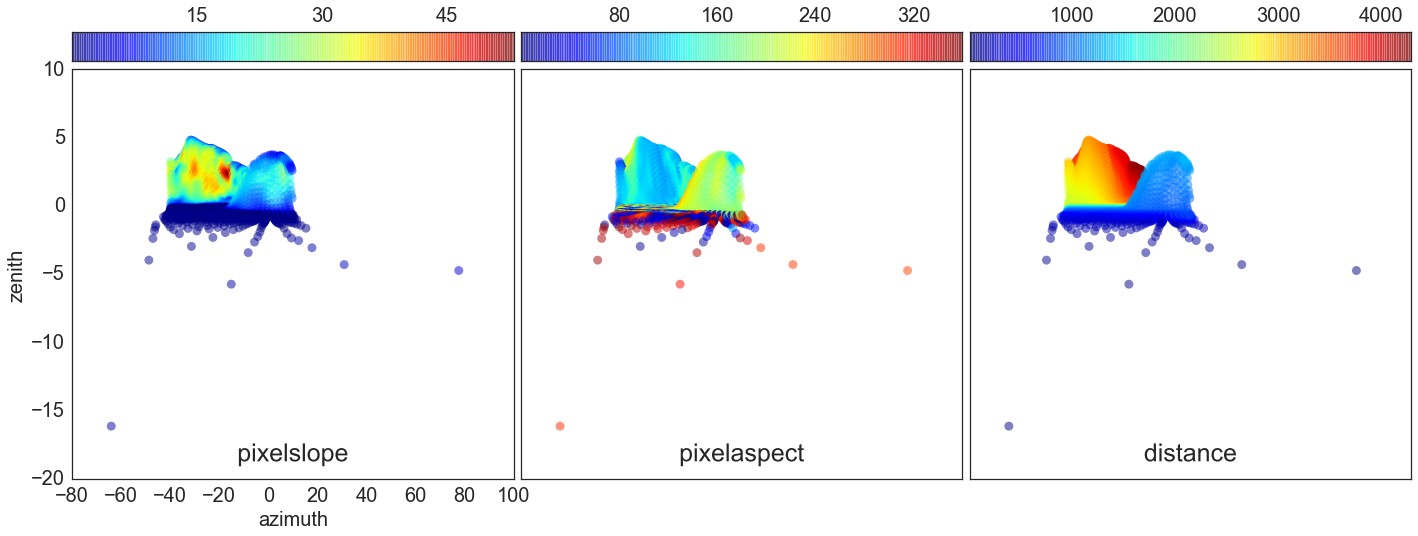

In [57]:
from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(24, 8))
grid = AxesGrid(fig, 111,  # similar to subplot(143)
                    nrows_ncols=(1, 3),
                    axes_pad=0.1,
                    label_mode="1",
                    share_all=True,
                    cbar_location="top",
                    cbar_mode="each",
                    cbar_size="7%",
                    cbar_pad="2%",
                    aspect=False
                    )

for i, which in enumerate(['pixelslope', 'pixelaspect', 'distance']):
    c = grid[i].scatter(data.azimuth, data.zenith, cmap='jet', c=data[which], alpha=0.5, lw=0, s=80)
    cbar = grid.cbar_axes[i].colorbar(c)
    # cbar.set_label("slope")
    cbar.solids.set_rasterized(True) 
    cbar.set_alpha(1)
    # cbar.draw_all()
    grid[i].set_ylabel('zenith')
    grid[i].set_xlabel('azimuth')
    pyphenocam.plotting.add_inner_title(grid[i], which, loc=8, font_kwargs=dict(size=25))
    resize_all(grid[i], 20)
    cbar.ax.tick_params(labelsize=20) 
# im = grid[0].imshow(Z, extent=extent, interpolation="nearest")
# grid.cbar_axes[i].colorbar(im)

In [64]:
big_pix_data = data[data.photopixelcount>300]

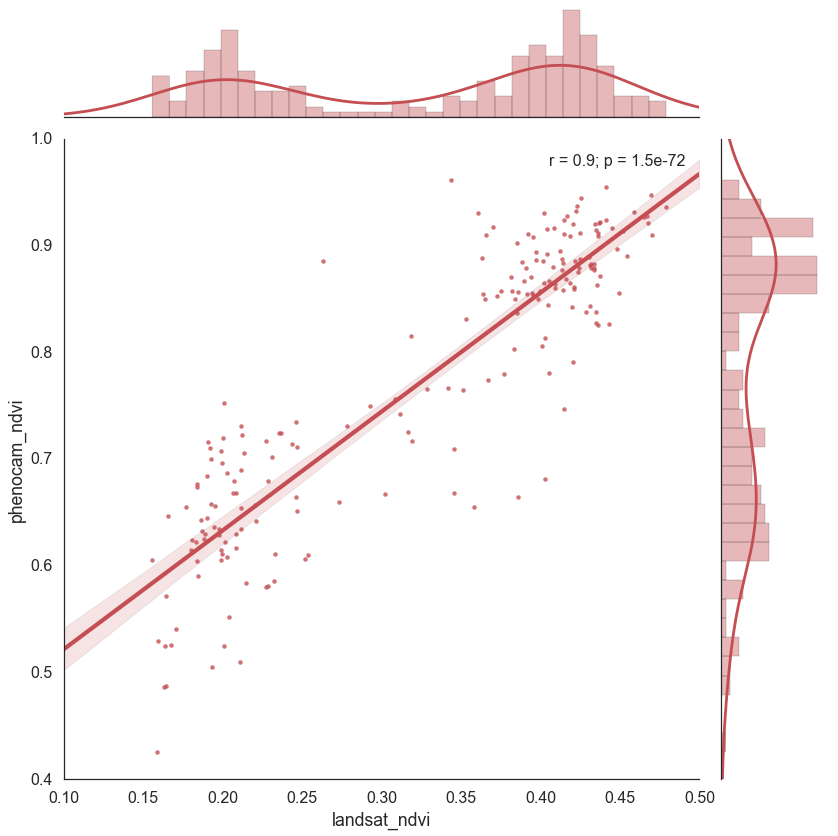

In [86]:
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context("poster")

d = big_pix_data
g = sns.jointplot("landsat_ndvi", "phenocam_ndvi", data=d, kind="reg",
                  xlim=(0.1, 0.5), ylim=(0.4, 1.),
                  color="r", size=12,
                  marginal_kws=dict(bins=30),
                  annot_kws=dict(stat="r"))
# plt.gca().plot(ys[:,0], ys[:,1], 'blue', linewidth=2, alpha=0.5)

fig = plt.gcf()
fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "CorrelationAllPoints_big_pix_data.jpg"), dpi=270)

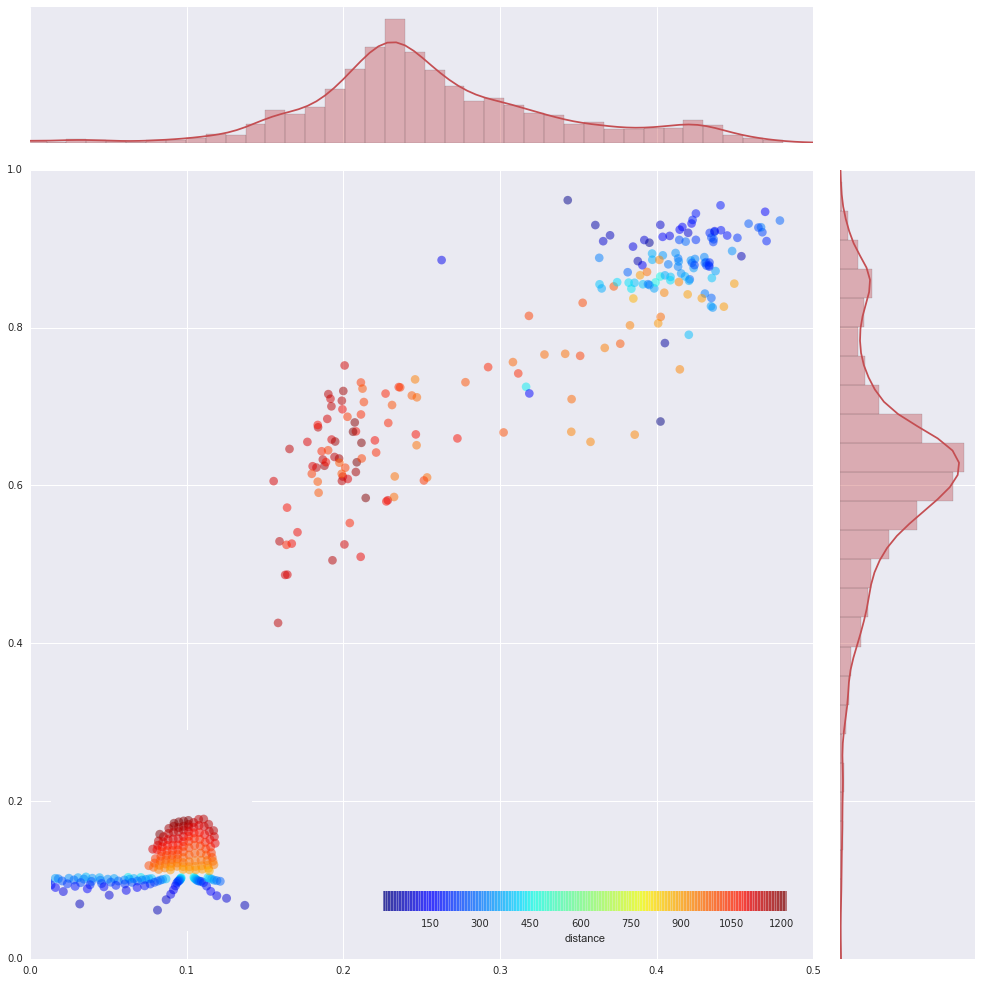

In [60]:
g = sns.jointplot("landsat_ndvi", "phenocam_ndvi", data=data, kind="reg",
                  xlim=(0.1, 0.5), ylim=(0.1, 1.), color="r", size=14)
g.ax_joint.cla()


d = big_pix_data
c = g.ax_joint.scatter(d.landsat_ndvi, d.phenocam_ndvi, c=d.distance, cmap='jet', alpha=0.5, lw=0, s=75)

# g.fig.colorbar(c)

g.ax_joint.set_xlim((0.0, 0.5))
g.ax_joint.set_ylim((0.0, 1.))

cbaxes = g.fig.add_axes([0.4, 0.09, 0.4, 0.02]) 
cbar = g.fig.colorbar(c, cax=cbaxes, orientation='horizontal')
cbar.set_label('distance')

fig = plt.gcf()
ax_inset = fig.add_axes([0.07, 0.07, 0.2, 0.2], frameon=True)
ax_inset.scatter(d.azimuth, d.zenith, cmap='jet', c=d[which], alpha=0.5, lw=0, s=80)
ax_inset.get_xaxis().set_visible(False)
ax_inset.get_yaxis().set_visible(False)
ax_inset.frameon = True
ax_inset.set_xlim(-40, 20)
ax_inset.set_ylim(-5, 10)
ax_inset.spines['top'].set_color='red'

fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "CorrelationAllPoints_wDist_big_pix_data.jpg"), dpi=270)

In [44]:
corrected_ndvi_m = np.ma.masked_where(index_grid.mask[:,:,0], corrected_ndvi)
mapped_output_m = np.ma.masked_where(index_grid.mask[:,:,0], mapped_output)

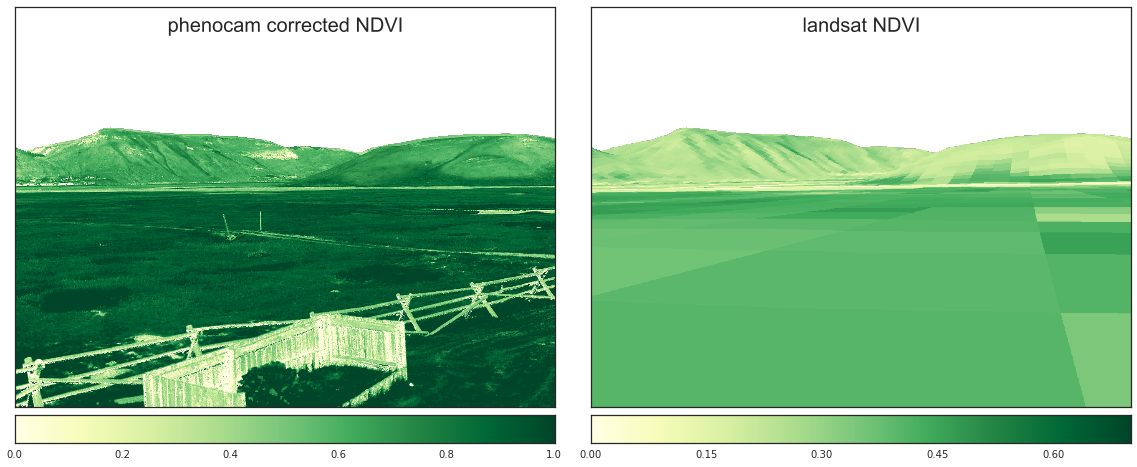

In [225]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im = np.arange(100)
im.shape = 10, 10

fig = plt.figure(1, figsize=(20, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 label_mode="1",
                    share_all=True,
                    cbar_location="bottom",
                    cbar_mode="each",
                    cbar_size="7%",
                    cbar_pad="2%",
                    )

#     Z, extent = get_demo_image()
#     for i in range(4):
#         im = grid[i].imshow(Z, extent=extent, interpolation="nearest")
#         grid.cbar_axes[i].colorbar(im)

#     for cax in grid.cbar_axes:
#         cax.toggle_label(False)

#     # This affects all axes because we set share_all = True.
#     grid.axes_llc.set_xticks([-2, 0, 2])
#     grid.axes_llc.set_yticks([-2, 0, 2])
# )

for i in range(2):
    pyphenocam.plotting.format_photo_axes(grid[i])
    
im1 = grid[0].imshow(corrected_ndvi_m, vmin=0, vmax=1, cmap=mpl.cm.YlGn)  # The AxesGrid object work as a list of axes.
im2 = grid[1].imshow(mapped_output_m, vmin=0, vmax=0.7, cmap=mpl.cm.YlGn)

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)

pyphenocam.plotting.add_inner_title(grid[0], "phenocam corrected NDVI", 9, font_kwargs=dict(size=20))
pyphenocam.plotting.add_inner_title(grid[1], "landsat NDVI", 9, font_kwargs=dict(size=20))

fig.savefig(os.path.join(r"J:\Projects\NCCSC\phenocam\Doc\Presentation", "MappedLandsat.jpg"), dpi=270)

### read in the MODIS data

In [9]:
modis_dname = os.path.join(output_dir, 'MODIS', 'subset')
modis_subset_fname = os.path.join(modis_dname, "modis_subset.tif")

In [11]:
modis = rasterio.open(modis_subset_fname)
modis_data = np.squeeze(modis.read(masked=True))
modis_proj = cartopy.crs.Sinusoidal.MODIS

modis_extents = [modis.bounds.left, modis.bounds.right, modis.bounds.bottom, modis.bounds.top]

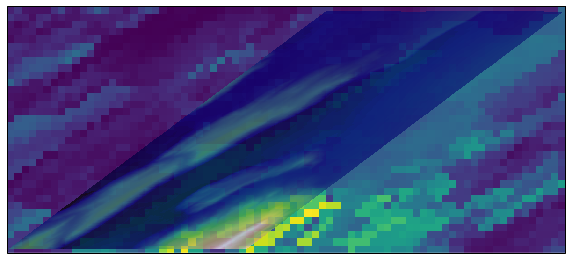

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(modis_data, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.viridis, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)


# Calculate the slope and aspect under a single modis pixel

In [13]:
modis_index_subset_fname = os.path.join(modis_dname, "modis_subset_index.tif")
modis_index = rasterio.open(modis_index_subset_fname)
modis_index_data = np.squeeze(modis_index.read(masked=True))

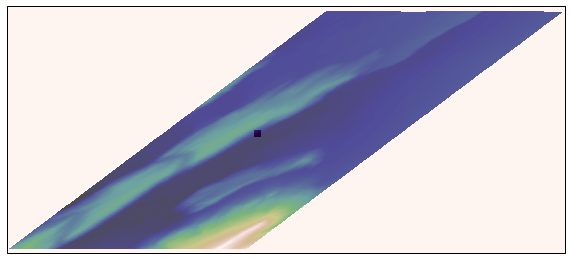

In [26]:
selected_pixel = np.zeros(modis_data.shape)
selected_pixel[17, 34] = 1.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(selected_pixel, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.Reds, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)

### Transform the selected pixels corner cordinates into the elevation crs

In [15]:
from affine import Affine
T1 = modis.affine * Affine.translation(0,0)

rc2xy = lambda r, c: (c, r) * T1

In [16]:
r, c = 17, 34

sel_pixulx, sel_pixuly = rc2xy (r+0, c+0)
sel_pixllx, sel_pixlly = rc2xy (r+1, c+0)
sel_pixurx, sel_pixury = rc2xy (r+0, c+1)
sel_pixlrx, sel_pixlry = rc2xy (r+1, c+1)

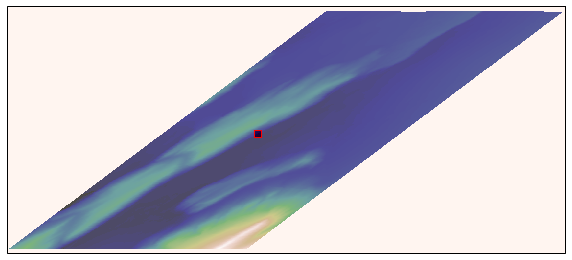

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(selected_pixel, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.Reds, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)

ax.plot([sel_pixulx,sel_pixurx], [sel_pixuly, sel_pixury], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixurx,sel_pixlrx], [sel_pixury, sel_pixlry], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixlrx,sel_pixllx], [sel_pixlry, sel_pixlly], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixllx,sel_pixulx], [sel_pixlly, sel_pixuly], 'k-', lw=1, c='red', transform=modis_proj)

In [64]:
dem_urx, dem_ury = list(landsat_proj.transform_point(sel_pixurx, sel_pixury, modis_proj))
dem_llx, dem_lly = list(landsat_proj.transform_point(sel_pixllx, sel_pixlly, modis_proj))
dem_ulx, dem_uly = list(landsat_proj.transform_point(sel_pixulx, sel_pixuly, modis_proj))
dem_lrx, dem_lry = list(landsat_proj.transform_point(sel_pixlrx, sel_pixlry, modis_proj))

In [65]:
dem_urx, dem_ury

(520341.93027473486, 4818685.86299797)

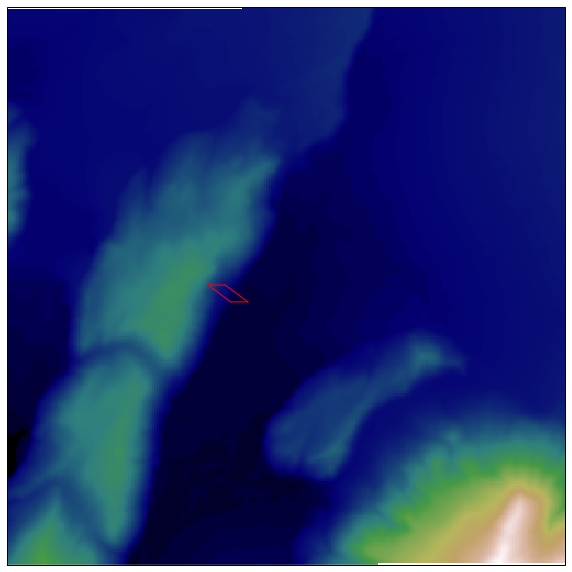

In [66]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')

ax.plot([dem_ulx,dem_urx], [dem_uly, dem_ury], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_urx,dem_lrx], [dem_ury, dem_lry], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_lrx,dem_llx], [dem_lry, dem_lly], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_llx,dem_ulx], [dem_lly, dem_uly], 'k-', lw=1, c='red', transform=landsat_proj)

In [67]:
from rasterio.features import rasterize
from shapely.geometry import Polygon, mapping

poly = Polygon(((dem_ulx, dem_uly), (dem_urx, dem_ury), (dem_lrx, dem_lry), (dem_llx, dem_lly)))
output = rasterize([poly], transform=elev.transform, out_shape=dem_data.shape)

dem_pix_subset = dem_data.copy()
dem_pix_subset.mask = output==0

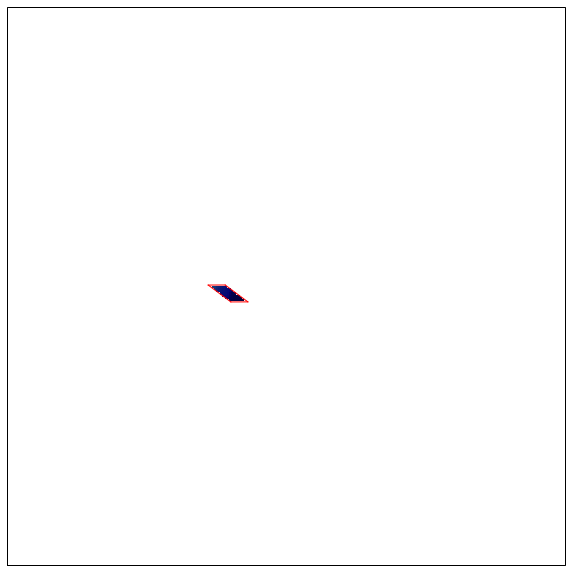

In [69]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

ax.imshow(dem_pix_subset, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none',
         vmax=dem_data.max(), vmin=dem_data.min())

ax.plot([dem_ulx,dem_urx], [dem_uly, dem_ury], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_urx,dem_lrx], [dem_ury, dem_lry], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_lrx,dem_llx], [dem_lry, dem_lly], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_llx,dem_ulx], [dem_lly, dem_uly], 'k-', lw=1, c='red', transform=landsat_proj)

In [42]:
from affine import Affine
T1 = landsat.affine * Affine.translation(0,0)

rc2xy = lambda rc: (rc[1], rc[0]) * T1

In [38]:
dem_indices = np.indices(dem_data.shape)
dem_xy = np.apply_along_axis(func1d=rc2xy ,arr=dem_indices, axis=0)

In [28]:
rc2xy(1, 1)

(517395.0, 4822455.0)

In [55]:
row = 41
col = 81

data = dem_data[row-1:row+2, col-1:col+2]
xy = dem_xy[:, row-1:row+2, col-1:col+2]

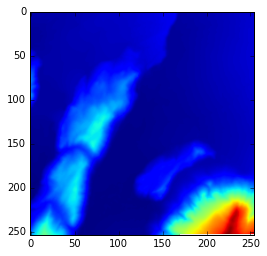

In [31]:
plt.imshow(dem_data)

In [56]:
xy

array([[[  519765.,   519795.,   519825.],
        [  519765.,   519795.,   519825.],
        [  519765.,   519795.,   519825.]],

       [[ 4821285.,  4821285.,  4821285.],
        [ 4821255.,  4821255.,  4821255.],
        [ 4821225.,  4821225.,  4821225.]]])

In [34]:
np.indices(data)

TypeError: Only length-1 arrays can be converted to Python scalars

In [54]:
dem_xy[:, 1, 1]

array([  517395.,  4822455.])

In [52]:
dem_xy.shape

(2L, 254L, 254L)

In [49]:
dem_indices.shape

(2L, 254L, 254L)

In [77]:


# Generate artificial data (2 regressors + constant)
nobs = 100
X = xy.reshape(2, 9).T
X = sm.add_constant(X)
y = data.flatten()

e = np.random.random(nobs)
y = np.dot(X, beta) + e

# Fit regression model
results = sm.OLS(y, X).fit()

# Inspect the results
print results.summary()


NameError: name 'nobs' is not defined

In [63]:
X = np.random.random((100, 2))
X.shape

(100L, 2L)

In [76]:
data.flatten()

masked_array(data = [1927.6507568359375 1927.958740234375 1928.2967529296875 1927.552734375
 1927.8743896484375 1928.2237548828125 1927.410400390625 1927.7431640625
 1928.089599609375],
             mask = [False False False False False False False False False],
       fill_value = -9999.0)

array([[  519765.,  4821285.],
       [  519795.,  4821285.],
       [  519825.,  4821285.],
       [  519765.,  4821255.],
       [  519795.,  4821255.],
       [  519825.,  4821255.],
       [  519765.,  4821225.],
       [  519795.,  4821225.],
       [  519825.,  4821225.]])

In [1]:
%matplotlib qt4
import matplotlib.pyplot as plt
# TODO add image and put this code into an appendix at the bottom
from mpl_toolkits.mplot3d import Axes3D

X = xy.reshape(2, 9).T
y = data.flatten()

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = xy[0,:,:], xy[1,:,:]
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


xpos2 = xx1.flatten()-5
ypos2 = xx2.flatten()-5
zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
dx2 = 15 * np.ones_like(xx1.flatten())
dy2 = 15 * np.ones_like(xx2.flatten())
dz2 = y.flatten() - y.min()

ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.05)

# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

NameError: name 'xy' is not defined

In [134]:
y.min()

1927.4104

In [92]:
xpos

array([ 0.26733116,  1.25870241,  2.25007367,  3.24144493,  0.26733116,
        1.25870241,  2.25007367,  3.24144493,  0.26733116,  1.25870241,
        2.25007367,  3.24144493,  0.26733116,  1.25870241,  2.25007367,
        3.24144493])

In [101]:
xpos2 = xx1.flatten()

In [116]:
ypos.shape

(16L,)

In [103]:
ypos2 = xx2.flatten()

In [93]:
zpos

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [105]:
np.zeros(y.flatten().shape)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [84]:
xx2[:2,:2]

array([[ 0.       ,  0.       ],
       [ 0.5010101,  0.5010101]])

In [98]:
xx1.flatten()

array([ 519765.,  519795.,  519825.,  519765.,  519795.,  519825.,
        519765.,  519795.,  519825.])

In [112]:
np.array(y.flatten())

array([ 1927.65075684,  1927.95874023,  1928.29675293,  1927.55273438,
        1927.87438965,  1928.22375488,  1927.41040039,  1927.74316406,
        1928.08959961], dtype=float32)

In [115]:
dz.shape

(16L,)

In [117]:
np.array(y.flatten()).shape

(9L,)

In [121]:
for thing in [xpos2, ypos2, zpos2, dx2, dy2, dz2]:
    print thing.shape

(9L,)
(9L,)
(9L,)
(1L,)
(1L,)
(9L,)


In [123]:
dx.shape

(16L,)

In [127]:
np.ones_like(xx1.flatten())

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

# Calculate azimuth and zenith

In [192]:
 import math
 x1,y1,z1 = 521203.13, 4815131.82, 1907.55
 x2,y2,z2 = 521199.24, 4815145.89, 1906.85
 distance = math.sqrt((x2-x1)**2+(y2-y1)**2+(z2 -z1)**2)
 print distance
 5.5910642993977451
 plunge = math.degrees(math.asin((z2-z1)/distance))
 print "zenith = ", plunge
 azimuth = math.degrees(math.atan2((x2-x1),(y2-y1)))
 print "azimuth = ", azimuth

14.6146159711
zenith =  -2.74536100269
azimuth =  -15.4547787471


In [82]:
data.describe()

,col,row,photopixelcount,landsatx,landsaty,landsatelevation,distance,azimuth,zenith,pixelslope,pixelaspect,landsat_ndvi,phenocam_ndvi
count,3045.000000,3045.000000,3045.000000,3045.000000,3.045000e+03,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3043.000000
mean,97.071593,173.318227,306.669951,520277.147783,4.817285e+06,1962.516839,2364.290515,-22.666530,1.013429,0.226475,152.871239,0.230320,0.575950
std,18.227234,35.870499,5624.299074,546.817021,1.076115e+03,86.413450,1143.847503,11.297286,1.531654,0.232597,78.066522,0.078095,0.153415
min,50.000000,103.000000,1.000000,518865.000000,4.815165e+06,1894.090820,20.386426,-51.218915,-0.905348,0.000030,0.137759,-0.045872,-0.765361
25%,84.000000,145.000000,22.000000,519885.000000,4.816305e+06,1894.795044,1244.422648,-31.733434,-0.217740,0.003222,110.370051,0.170491,0.538075
50%,96.000000,170.000000,56.000000,520245.000000,4.817385e+06,1908.207275,2635.288627,-23.268073,0.188492,0.168421,128.242961,0.202638,0.589214
75%,110.000000,206.000000,109.000000,520665.000000,4.818135e+06,2027.839966,3323.976430,-16.177811,2.368596,0.443017,191.798989,0.297927,0.628333
max,134.000000,244.000000,275196.000000,521385.000000,4.819395e+06,2178.184082,4307.990151,16.214119,4.829316,0.925046,359.589529,0.444978,1.000000


## landsat pheno mapped series

In [50]:
scene_dname = os.path.join(base_dname, "Landsat", "SceneSubset")
ndvi_fnames = [f for f in os.listdir(scene_dname) if 'ndvi' in f]
gcc_fnames = [f for f in os.listdir(scene_dname) if 'gcc' in f]

In [51]:
def map_to_phenocam(landsat_data):
    mapped_output = np.zeros(np.squeeze(index_grid[:,:,1]).shape)
    for col, row in uniq:

        single_pixel = np.logical_and(index_grid[:,:,0]==col, index_grid[:,:,1]==row)
        single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                        (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))
        phenopixcount = np.count_nonzero(single_pixel)
        try:
            landsatx, landsaty = dem_xy[:, row, col]
            pix_elev = dem_data[row, col]
            landsat_ndvi = landsat_data[row, col]

            mapped_output[single_pixel>0.95] = landsat_ndvi
        except IndexError:
            print "skipping", col, row

    mapped_output_m = np.ma.masked_where(index_grid.mask[:,:,0], mapped_output)
    return mapped_output_m

In [56]:
for fname in ndvi_fnames:
    year = int(fname[9:13])
    jday = int(fname[13:16])
    landsat_date = datetime.datetime(year, 1, 1, 12) + datetime.timedelta(jday)
    
    landsat_fname = os.path.join(scene_dname, fname)
    landsat = rasterio.open(landsat_fname)
    landsat_data = np.squeeze(landsat.read(masked=True))
    
    cloud_data = rasterio.open(landsat_fname.replace('ndvi', 'cloud')).read(1)
    landsat_data[cloud_data==4] = 44
    
    
    landsat_just_fname = os.path.split(landsat_fname)[-1]
    mapped_dname = os.path.join(scene_dname, 'mapped')
    if not os.path.exists(mapped_dname):
        os.makedirs(mapped_dname)
    
    out_fname = os.path.join(mapped_dname, 'landsat_{dt.year}_{dt.month:02d}_{dt.day:02d}.npy'.format(dt=landsat_date))
    if not os.path.exists(out_fname):
        print out_fname
        mapped = map_to_phenocam(landsat_data)
        data = mapped.data
        data[mapped.mask]=-255
        np.save(out_fname, data)
    else:
        print("\tskipping " + out_fname)
    
#     out_fname2 = os.path.join(scene_dname, 'mapped', landsat_just_fname.replace('subset.tif', 'mapped.npy'))
#     os.rename(out_fname, out_fname2)
#     print out_fname


	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_01_07.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_01_23.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_02_08.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_02_24.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_03_12.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_03_28.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_04_13.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\mapped\landsat_2015_04_29.npy
	skipping J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefu

In [138]:
for fname in landsat_fnames:
    year = int(fname[9:13])
    jday = int(fname[13:16])
    landsat_date = datetime.datetime(year, 1, 1, 12) + datetime.timedelta(jday)
    
    landsat_fname = os.path.join(scene_dname, fname)
    print landsat_fname
    landsat = rasterio.open(landsat_fname)
    landsat_data = np.squeeze(landsat.read(masked=True))
    break
    
#     mapped = map_to_phenocam(landsat_data)
    landsat_just_fname = os.path.split(landsat_fname)[-1]
    out_fname = os.path.join(scene_dname, 'mapped', 'landsat_{dt.year}_{dt.month:02d}_{dt.day:02d}.npy'.format(dt=landsat_date))
    out_fname2 = os.path.join(scene_dname, 'mapped', landsat_just_fname.replace('subset.tif', 'mapped.npy'))
    os.rename(out_fname, out_fname2)
#     print out_fname
#     np.save(out_fname, mapped)

J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\LC80380302015214LGN00_subset.tif


In [141]:
print landsat_fname

J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\Landsat\SceneSubset\LC80380302015214LGN00_subset.tif


In [130]:
mapped_fnames = os.listdir(os.path.join(scene_dname, 'mapped'))

data = {}
for i, fname in enumerate(mapped_fnames):
    print i
    fname_full = os.path.join(scene_dname, 'mapped', fname)
    landsat_fname = fname_full.replace('\\mapped', '')
    landsat = rasterio.open(landsat_fname)
    landsat_data = np.squeeze(landsat.read(masked=True))
    
    data[i] = (np.load(fname_full), landsat_data)
               
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [170]:
print(__doc__)

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
# Licence: BSD 3 clause

import numpy as np
from sklearn.gaussian_process import GaussianProcess
from matplotlib import pyplot as pl

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = data.landsat_ndvi

# Observations
y = data.phenocam_ndvi

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(X).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# # Plot the function, the prediction and the 95% confidence interval based on
# # the MSE
# fig = pl.figure()
# pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
# pl.plot(X, y, 'r.', markersize=10, label=u'Observations')
# pl.plot(x, y_pred, 'b-', label=u'Prediction')
# pl.fill(np.concatenate([x, x[::-1]]),
#         np.concatenate([y_pred - 1.9600 * sigma,
#                        (y_pred + 1.9600 * sigma)[::-1]]),
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')
# pl.xlabel('$x$')
# pl.ylabel('$f(x)$')
# pl.ylim(-10, 20)
# pl.legend(loc='upper left')

#----------------------------------------------------------------------
# now the noisy case
# X = np.linspace(0.1, 9.9, 20)
# X = np.atleast_2d(X).T

# # Observations and noise
# y = f(X).ravel()
# dy = 0.5 + 1.0 * np.random.random(y.shape)
# noise = np.random.normal(0, dy)
# y += noise

# # Mesh the input space for evaluations of the real function, the prediction and
# # its MSE
# x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=(dy / y) ** 2,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

pl.show()

Automatically created module for IPython interactive environment


ValueError: Found arrays with inconsistent numbers of samples: [   1 3044]

In [177]:
X = data.landsat_ndvi
X = np.atleast_2d(X).T

# Observations and noise
y = data.phenocam_ndvi
dy = 0.5 + 1.0 * np.random.random(y.shape)
# noise = np.random.normal(0, dy)
# y += noise

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(-1, 1, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=0.1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

pl.show()

KeyboardInterrupt: 

In [178]:
data.to_pickle(r"c:\temp\data.pd")

In [174]:
dy.shape

(20L,)

In [148]:
sys.getsizeof(data)

2488448